In [2]:
cd scripts/

/Users/anil/Code/facebook/scripts


In [31]:
import numpy as np
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import grid_generation as grid
import sk_learn_models as sk_learn
from sklearn.cross_validation import train_test_split
import pickle

from sklearn.preprocessing import LabelEncoder

In [116]:
def transform_x(X, x_transformer = None):
    """
    X = [[x, y, a, t]]
    """
    fw = [500., 1000., 4., 3., 2., 10., 10.]
    minute_v = X[:, 3]%60
    hour_v = X[:, 3]//60
    weekday_v = hour_v//24
    month_v = weekday_v//30
    year_v = (weekday_v//365 + 1)*fw[5]
    hour_v = ((hour_v%24 + 1) + minute_v/60.0)*fw[2]
    weekday_v = (weekday_v%7 + 1)*fw[3]
    month_v = (month_v%12 +1)*fw[4]
    accuracy_v = np.log10(X[:, 2])*fw[6]
    x_v = X[:, 0]*fw[0]
    y_v = X[:, 1]*fw[1]
    return np.hstack((x_v.reshape(-1, 1),\
                     y_v.reshape(-1, 1),\
                     accuracy_v.reshape(-1, 1),\
                     hour_v.reshape(-1, 1),\
                     weekday_v.reshape(-1, 1),\
                     month_v.reshape(-1, 1),\
                     year_v.reshape(-1, 1)))

def transform_x1(X, x_transformer = None):
    """
    X = [[x, y, a, t]]
    """
    fw = [1., 1., 1., 1., 1., 1., 1.]
    minute_v = X[:, 3]%60
    hour_v = X[:, 3]//60
    weekday_v = hour_v//24
    month_v = weekday_v//30
    year_v = (weekday_v//365 + 1)*fw[5]
    hour_v = ((hour_v%24 + 1) + minute_v/60.0)*fw[2]
    weekday_v = (weekday_v%7 + 1)*fw[3]
    month_v = (month_v%12 +1)*fw[4]
    accuracy_v = np.log10(X[:, 2])*fw[6]
    x_v = X[:, 0]*fw[0]
    y_v = X[:, 1]*fw[1]
    return np.hstack((x_v.reshape(-1, 1),\
                     y_v.reshape(-1, 1),\
                     accuracy_v.reshape(-1, 1),\
                     hour_v.reshape(-1, 1),\
                     weekday_v.reshape(-1, 1),\
                     month_v.reshape(-1, 1),\
                     year_v.reshape(-1, 1)))

def transform_y(y, y_transformer = None):
    """
    place_ids to encoded array
    """
    y = y.astype(int)
    if y_transformer == None:
        label_encoder = LabelEncoder()
        label_encoder.fit(y)
        y_transformer = {'encoder': label_encoder}
    new_y = y_transformer['encoder'].transform(y).reshape(-1, 1)
    return (new_y, y_transformer)

def map3eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,4)]
    metric = 0.
    for i in range(3):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@3', metric

In [9]:
data = np.loadtxt('../grid2_800_400_200_100/grid_data_0_0.csv', delimiter = ',')
X, Y, xd, yd = 400, 100, 50, 10

In [14]:
small_mask = (data[:, 1] < 0.45) & (data[:, 2] < 0.11)
small_data = data[small_mask,:]

In [21]:
M = pickle.load(open('../grid2_800_400_200_100/cardinality_pickle.pkl', 'rb'))

In [64]:
train, test = train_test_split(small_data, test_size = 0.02)

In [65]:
mask = np.array(map(lambda x: M[0][0][x] > 20, train[:, 5]))
card_train = train[mask, :]
print card_train.shape
print train.shape

(14510, 6)
(14964, 6)


In [66]:
X = transform_x(card_train[:, (1, 2, 3, 4)])
y_orig, enc = transform_y(small_data[:, 5])
y, enc = transform_y(card_train[:, 5], enc)
test_X = transform_x(test[:, (1, 2, 3, 4)])
test_y, enc = transform_y(test[:, 5], enc)
print X.shape
print y.shape
print test_X.shape
print test_y.shape

dtrain = xgb.DMatrix(X, label=np.ravel(y))
dtest = xgb.DMatrix(test_X, label=np.ravel(test_y))

(14510, 7)
(14510, 1)
(306, 7)
(306, 1)


In [125]:
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = len(enc['encoder'].classes_)
param['eval_metric'] = ['merror', 'mlogloss']

watchlist = [ (dtrain,'train'), (dtest, 'test') ]
num_round = 5
er = {}
print param

{'num_class': 396, 'silent': 1, 'eval_metric': ['merror', 'mlogloss'], 'nthread': 4, 'eta': 0.1, 'objective': 'multi:softprob', 'max_depth': 6}


In [105]:
bst = xgb.train(param, dtrain, num_round, watchlist, verbose_eval = True, evals_result = er );

[0]	train-merror:0.491592	train-mlogloss:3.16631	test-merror:0.562092	test-mlogloss:3.6628
[1]	train-merror:0.465059	train-mlogloss:2.64402	test-merror:0.555556	test-mlogloss:3.17236
[2]	train-merror:0.447278	train-mlogloss:2.369	test-merror:0.542484	test-mlogloss:2.94533
[3]	train-merror:0.430875	train-mlogloss:2.17426	test-merror:0.539216	test-mlogloss:2.80048
[4]	train-merror:0.417505	train-mlogloss:2.02123	test-merror:0.526144	test-mlogloss:2.68952
[5]	train-merror:0.408546	train-mlogloss:1.89711	test-merror:0.51634	test-mlogloss:2.61055
[6]	train-merror:0.395038	train-mlogloss:1.79101	test-merror:0.503268	test-mlogloss:2.54456
[7]	train-merror:0.384149	train-mlogloss:1.6996	test-merror:0.496732	test-mlogloss:2.48905
[8]	train-merror:0.372984	train-mlogloss:1.62008	test-merror:0.486928	test-mlogloss:2.44164
[9]	train-merror:0.361061	train-mlogloss:1.54916	test-merror:0.490196	test-mlogloss:2.40084
[10]	train-merror:0.347622	train-mlogloss:1.48398	test-merror:0.48366	test-mlogloss:2

In [117]:
bst = xgb.train(param, dtrain, num_round, watchlist, verbose_eval = True, evals_result = er, feval = map3eval );

[0]	train-MAP@3:0.627981	test-MAP@3:0.542484
[1]	train-MAP@3:0.652722	test-MAP@3:0.555556
[2]	train-MAP@3:0.672364	test-MAP@3:0.565359
[3]	train-MAP@3:0.689593	test-MAP@3:0.571895
[4]	train-MAP@3:0.701861	test-MAP@3:0.578431
[5]	train-MAP@3:0.712267	test-MAP@3:0.584967
[6]	train-MAP@3:0.723225	test-MAP@3:0.598039
[7]	train-MAP@3:0.732254	test-MAP@3:0.604575
[8]	train-MAP@3:0.741282	test-MAP@3:0.607843
[9]	train-MAP@3:0.749897	test-MAP@3:0.611111
[10]	train-MAP@3:0.759407	test-MAP@3:0.611111
[11]	train-MAP@3:0.766988	test-MAP@3:0.611111
[12]	train-MAP@3:0.774294	test-MAP@3:0.617647
[13]	train-MAP@3:0.780841	test-MAP@3:0.624183
[14]	train-MAP@3:0.78725	test-MAP@3:0.627451
[15]	train-MAP@3:0.792833	test-MAP@3:0.630719
[16]	train-MAP@3:0.798553	test-MAP@3:0.637255
[17]	train-MAP@3:0.804342	test-MAP@3:0.640523
[18]	train-MAP@3:0.810338	test-MAP@3:0.640523
[19]	train-MAP@3:0.815644	test-MAP@3:0.643791
[20]	train-MAP@3:0.820193	test-MAP@3:0.643791
[21]	train-MAP@3:0.824673	test-MAP@3:0.647059

In [123]:
bst123 = xgb.train(param, dtrain, num_round, verbose_eval = True, evals_result = er );

XGBoostError: value 0for Parameter num_class should be greater equal to 1

In [115]:
preds.shape

(306, 396)

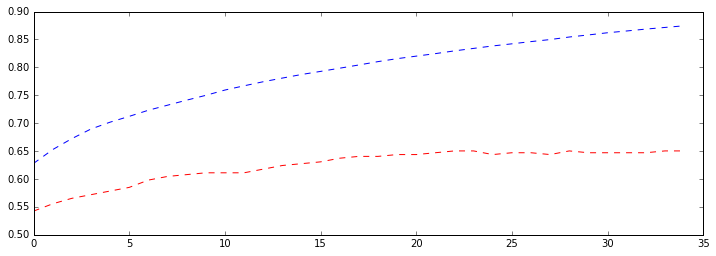

In [120]:
plt.plot(er['test']['MAP@3'], 'r--', er['train']['MAP@3'], 'b--')

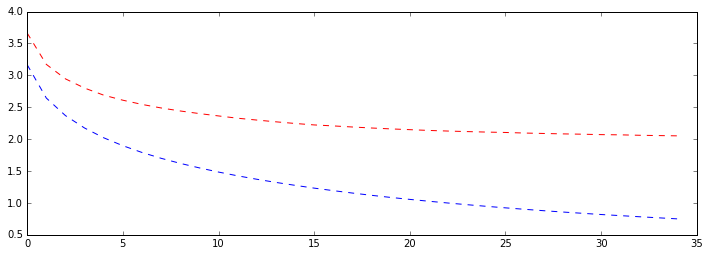

In [107]:
plt.plot(er['test']['mlogloss'], 'r--', er['train']['mlogloss'], 'b--')

In [110]:
X1 = transform_x1(card_train[:, (1, 2, 3, 4)])
y_orig, enc = transform_y(small_data[:, 5])
y, enc = transform_y(card_train[:, 5], enc)
test_X1 = transform_x1(test[:, (1, 2, 3, 4)])
test_y, enc = transform_y(test[:, 5], enc)
print X1.shape
print y.shape
print test_X1.shape
print test_y.shape

dtrain1 = xgb.DMatrix(X1, label=np.ravel(y))
dtest1 = xgb.DMatrix(test_X1, label=np.ravel(test_y))

(14510, 7)
(14510, 1)
(306, 7)
(306, 1)


In [111]:
param1 = {}
# use softmax multi-class classification
param1['objective'] = 'multi:softprob'
# scale weight of positive examples
param1['eta'] = 0.1
param1['max_depth'] = 6
param1['silent'] = 1
param1['nthread'] = 4
param1['num_class'] = 396
param1['eval_metric'] = ['merror', 'mlogloss']

watchlist1 = [ (dtrain1,'train'), (dtest1, 'test') ]
num_round1 = 35
er1 = {}

In [112]:
bst1 = xgb.train(param1, dtrain1, num_round1, watchlist1, verbose_eval = True, evals_result = er1 );

[0]	train-merror:0.491592	train-mlogloss:3.16631	test-merror:0.562092	test-mlogloss:3.6628
[1]	train-merror:0.465059	train-mlogloss:2.64402	test-merror:0.555556	test-mlogloss:3.17236
[2]	train-merror:0.447278	train-mlogloss:2.369	test-merror:0.542484	test-mlogloss:2.94533
[3]	train-merror:0.430875	train-mlogloss:2.17426	test-merror:0.539216	test-mlogloss:2.80048
[4]	train-merror:0.417505	train-mlogloss:2.02123	test-merror:0.526144	test-mlogloss:2.68952
[5]	train-merror:0.408546	train-mlogloss:1.89711	test-merror:0.51634	test-mlogloss:2.61055
[6]	train-merror:0.395038	train-mlogloss:1.79101	test-merror:0.503268	test-mlogloss:2.54455
[7]	train-merror:0.384149	train-mlogloss:1.6996	test-merror:0.496732	test-mlogloss:2.48904
[8]	train-merror:0.372984	train-mlogloss:1.62008	test-merror:0.486928	test-mlogloss:2.44164
[9]	train-merror:0.361061	train-mlogloss:1.54916	test-merror:0.490196	test-mlogloss:2.40083
[10]	train-merror:0.347622	train-mlogloss:1.48398	test-merror:0.48366	test-mlogloss:2

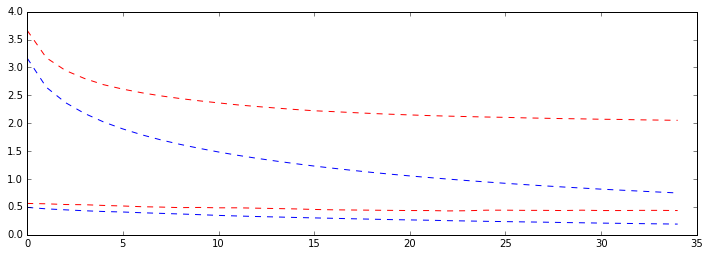

In [113]:
plt.plot(er1['test']['merror'], 'r--', er1['train']['merror'], 'b--')
plt.plot(er1['test']['mlogloss'], 'r--', er1['train']['mlogloss'], 'b--')

In [127]:
probs = bst.predict(xgb.DMatrix(test_X))

In [128]:
probs.shape

(306, 396)

In [130]:
sum(probs[0])

1.0000000036707206

In [6]:
import xgboost_model as xgbm
import grid_generation as grid
reload(grid)
reload(xgbm)

<module 'xgboost_model' from 'xgboost_model.pyc'>

In [7]:
g = grid.Grid(400, 100, 50, 10, pref = 'grid1', files_flag=True, train_file='../main_train_0.02_5.csv')
xgbm1 = xgbm.XGB_Model(grid = g, threshold = 7, cross_validation_file='../main_cv_0.02_5.csv')
xgbm1.train_and_predict_parallel('../parallel_submission.csv')

converting test data to grid wise
converting cv data to grid wise
mean precision of cross validation set 0.660828459102
generating 0 row of test dataprocessing row 0
processing row 4
processing column 0 of row 0
processing column 0 of row 4
processing column 1 of row 0processing column 1 of row 4

processing column 2 of row 0processing column 2 of row 4

processing column 3 of row 0processing column 3 of row 4

processing column 4 of row 0processing column 4 of row 4

processing column 5 of row 0processing column 5 of row 4

processing column 6 of row 0processing column 6 of row 4

processing column 7 of row 0processing column 7 of row 4

processing column 8 of row 0processing column 8 of row 4

processing column 9 of row 0processing column 9 of row 4

processing column 10 of row 0processing column 10 of row 4

processing column 11 of row 0processing column 11 of row 4

processing column 12 of row 0processing column 12 of row 4

processing column 13 of row 0processing column 13 of row 

xgboost_model.py:336: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  test_rows = filter(lambda x: x != None, test_rows)
xgboost_model.py:337: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  cv_rows = filter(lambda x: x != None, cv_rows)
/usr/local/lib/python2.7/site-packages/numpy/lib/npyio.py:891: UserWarning: loadtxt: Empty input file: "../grid1_400_100_50_10/grid_data_25_100.csv"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


processing column 27 of row 1processing column 27 of row 5

processing column 28 of row 1processing column 28 of row 5

processing column 29 of row 1processing column 29 of row 5

processing column 30 of row 1processing column 30 of row 5

processing column 31 of row 1processing column 31 of row 5

processing column 32 of row 1processing column 32 of row 5

processing column 33 of row 1processing column 33 of row 5

processing column 34 of row 1processing column 34 of row 5

processing column 35 of row 1processing column 35 of row 5

processing column 36 of row 1processing column 36 of row 5

processing column 37 of row 1processing column 37 of row 5

processing column 38 of row 1processing column 38 of row 5

processing column 39 of row 1processing column 39 of row 5

processing column 40 of row 1processing column 40 of row 5

processing column 41 of row 1processing column 41 of row 5

processing column 42 of row 1processing column 42 of row 5

processing column 43 of row 1processing 

In [ ]:
ubuntu@ip-172-30-0-34:~/facebook/scripts$ ls -ld /proc/2599
dr-xr-xr-x 9 ubuntu ubuntu 0 Jun 27 10:24 /proc/2599
ubuntu@ip-172-30-0-34:~/facebook/scripts$ date
Mon Jun 27 20:47:54 UTC 2016
        
        
ubuntu@ip-172-30-0-195:~/facebook$ ls -ld /proc/2248
dr-xr-xr-x 9 ubuntu ubuntu 0 Jun 28 06:30 /proc/2248
ubuntu@ip-172-30-0-195:~/facebook$ date
Tue Jun 28 08:24:55 UTC 2016